## tftb工具箱进行信号处理

### 生成信号
`fmodany()`根据输入的频率调制信号

d:\anaconda3\.conda\envs\sig_processing\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\anaconda3\.conda\envs\sig_processing\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


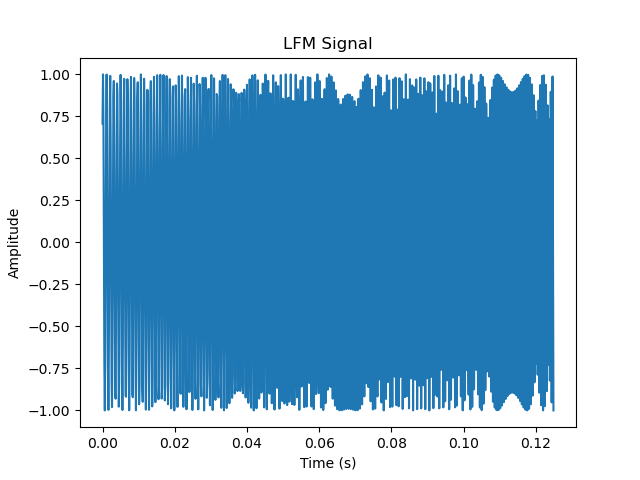

In [ ]:
from tftb.generators import fmlin
from tftb.generators.frequency_modulated import fmodany

SampleNum = 1000
fmin,fmax = 1000,2100
fs = 8000
f_limit = fs
t = np.arange(SampleNum)/fs

fmin_norm,fmax_norm = fmin/f_limit,fmax/f_limit

y,f_norm = fmlin(SampleNum,fmin_norm,fmax_norm)#fmax_norm最大为0.5  归一化频率时的分母是fs
signal = fmodany(f_norm)
t = np.arange(SampleNum)/fs

plt.figure()
plt.plot(t,signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('LFM Signal')
plt.show()

### 时频变换

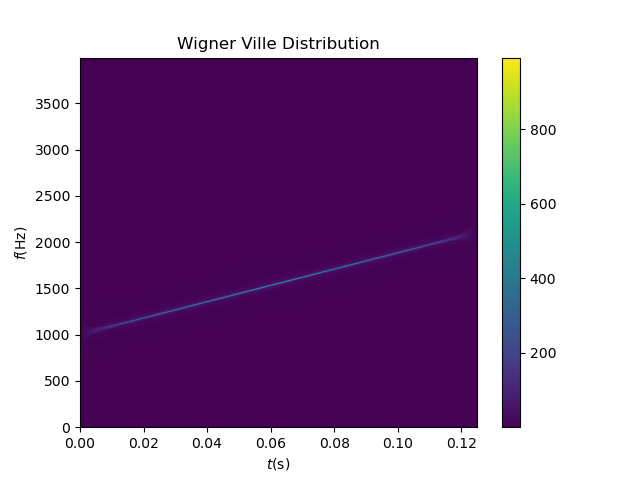

In [ ]:
from tftb.processing import WignerVilleDistribution
# wvd = WignerVilleDistribution(signal)
# amp,time_num,freq_norm = wvd.run()
# t = time_num*(1/fs)
# f = freq_norm*fs

# wvd.run()
# # 不指定 ax，让 tftb 自己处理
# wvd.plot(kind='cmap', cmap='viridis')
# # 获取当前的 axes
# ax=plt.gca()
# plt.colorbar(ax.images[0])

wvd = WignerVilleDistribution(signal)
amp,time_num,freq_norm = wvd.run()
t = time_num*(1/fs)
f = freq_norm*fs

plt.figure()
plt.imshow(np.abs(amp), 
            extent=[t[0],t[-1],f[0],f[-1]],
            aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
plt.xlabel(r'$t$(s)')
plt.ylabel(r'$f$(Hz)')
plt.title("Wigner Ville Distribution");

### 模糊函数
- 窄带模糊函数

m序列

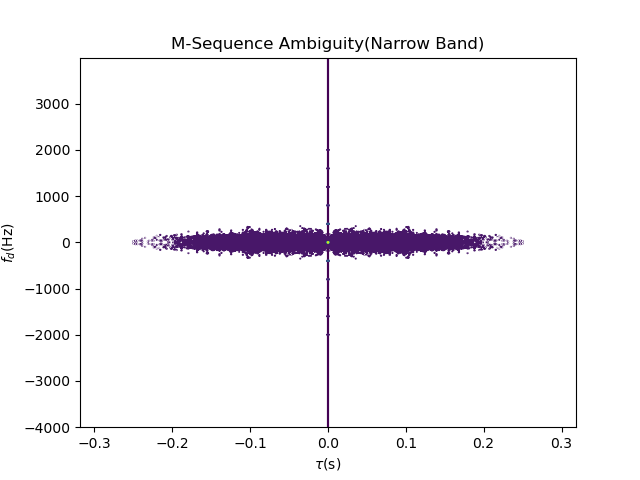

(-50.0, 50.0)

In [ ]:
import numpy as np
from tftb.processing.ambiguity import narrow_band
import matplotlib.pyplot as plt
%matplotlib widget
from module.sequence import m_seq


gen_435 = [1, 0, 0, 0, 1, 1, 1, 0, 1]  # x^8 + x^4 + x^3 + x^2 + 1
init_state = [1, 0, 1, 0, 1, 0, 1, 0]   # 8位初始状态，必须非零
    
# 生成m序列
M_array = m_seq(gen_435, init_state)
M_array = M_array*2-1

fs = 8000
fmax = fs
fc  = 2000

total_time = 0.635  # 总时间（秒）
N = len(M_array)
T_pulse = total_time / N

sub_pulse_t = np.arange(0, T_pulse, 1/fs)

sub_pulse = np.exp(1j*2*np.pi*fc*sub_pulse_t)
sig = np.concatenate([sub_pulse * m for m in M_array])
t = np.arange(0, len(sig))/fs

af,x,y = narrow_band(sig)
x ,y = x/fs,y*fs


x,y = np.meshgrid(x,y)

plt.figure()
#plt.pcolormesh(x,y,np.abs(af)**2)
#plt.colorbar()
plt.contour(x,y,np.abs(af)/np.max(np.abs(af)),16)

plt.xlabel(r'$\tau$(s)')
plt.ylabel(r'$f_d$(Hz)')
plt.title('M-Sequence Ambiguity(Narrow Ban d)')
plt.ylim(-50,50)
plt.show()

costas序列

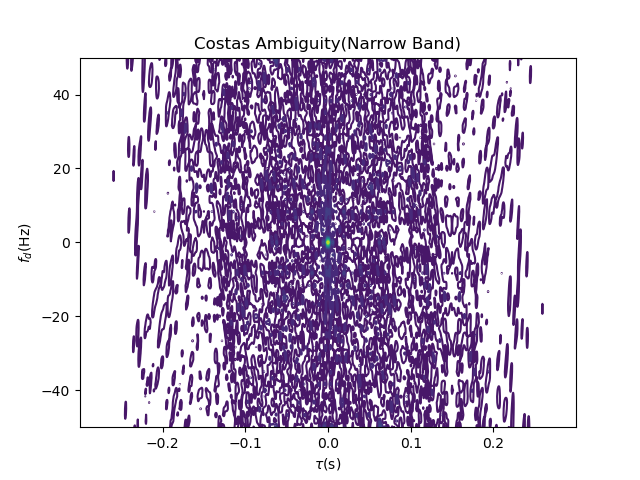

In [ ]:
from module.sequence import costas_seq
from tftb.processing.ambiguity import narrow_band
costas_list, method_list = costas_seq(30, num=3)
costas_list,method_list

costas_array = costas_list[0]

fc = 2000
B = 200
f_hop = B/len(costas_array)
f_start = fc - B/2
duration = 0.6
N = int(duration*fs)
sub_t_len = duration/len(costas_array)

sub_t = np.arange(0,0.02, 1/fs)

sig = np.concatenate([np.exp(1j*2*np.pi*(f_start+i*f_hop)*sub_t) for i in costas_array])

af,x,y = narrow_band(sig)
tau,doppler = x/fs,y*fs

tau,doppler = np.meshgrid(tau,doppler)

plt.figure()
#plt.pcolormesh(x,y,np.abs(af)**2)
#plt.colorbar()
plt.contour(tau,doppler,np.abs(af)/np.max(np.abs(af)),16)

plt.xlabel(r'$\tau$(s)')
plt.ylabel(r'$f_d$(Hz)')
plt.title('Costas Ambiguity(Narrow Band)')
plt.ylim(-50,50)
plt.show()


- 宽带模糊函数

m序列

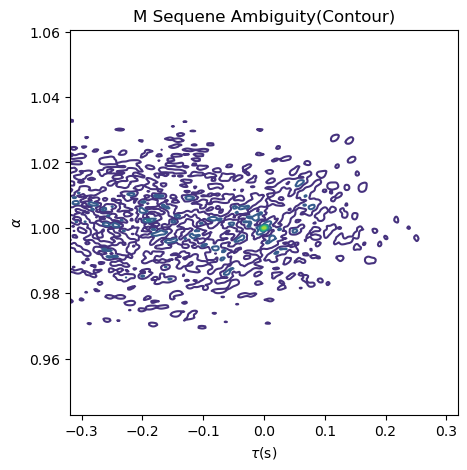

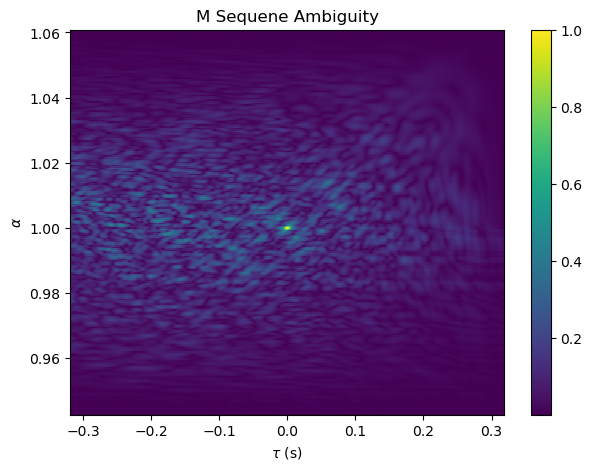

In [ ]:
from module.sequuence import m_seq
import numpy as np
import matplotlib.pyplot as plt

gen_435 = [1, 0, 0, 0, 1, 1, 1, 0, 1]  # x^8 + x^4 + x^3 + x^2 + 1
init_state = [1, 0, 1, 0, 1, 0, 1, 0]   # 8位初始状态，必须非零
    
# 生成m序列
M_array = m_seq(gen_435, init_state)
M_array = M_array*2-1

fs = 8000
fmax = fs
fc  = 2000

total_time = 0.635  # 总时间（秒）
N = len(M_array)
T_pulse = total_time / N

sub_pulse_t = np.arange(0, T_pulse, 1/fs)

sub_pulse = np.exp(1j*2*np.pi*fc*sub_pulse_t)
sig = np.concatenate([sub_pulse * m for m in M_array])
t = np.arange(0, len(sig))/fs


# plt.figure(figsize=(10, 5))
# plt.plot(t,sig.real)
# plt.show()

#绘制模糊函数
from tftb.processing.ambiguity import wide_band

waf, tau, log_theta = wide_band(sig, 0.33, 0.35, N)
tau = tau*(1/fs)
alpha = np.exp(log_theta)

TAU, ALPHA = np.meshgrid(tau, alpha)

    #等高线图
plt.figure(figsize=(5, 5))
plt.contour(tau, alpha, np.abs(waf)/np.max(np.abs(waf)))
plt.xlabel(r"$\tau$(s)")
plt.ylabel(r"$\alpha$")
plt.title("M Sequene Ambiguity(Contour)")
plt.show()


plt.figure(figsize=(7, 5))
#plt.imshow(np.abs(waf)/np.max(np.abs(waf)), 
#            extent=[tau[0], tau[-1], alpha[0], alpha[-1]],
#            aspect='auto', origin='lower', cmap='viridis')
plt.pcolormesh(TAU, ALPHA, np.abs(waf)/np.max(np.abs(waf)))
plt.colorbar()
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$\alpha$')
plt.title("M Sequene Ambiguity")
plt.show()

costas序列

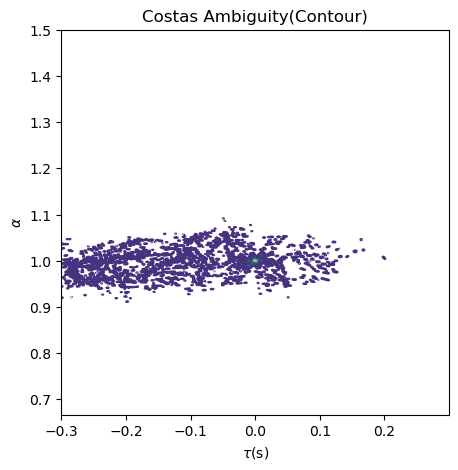

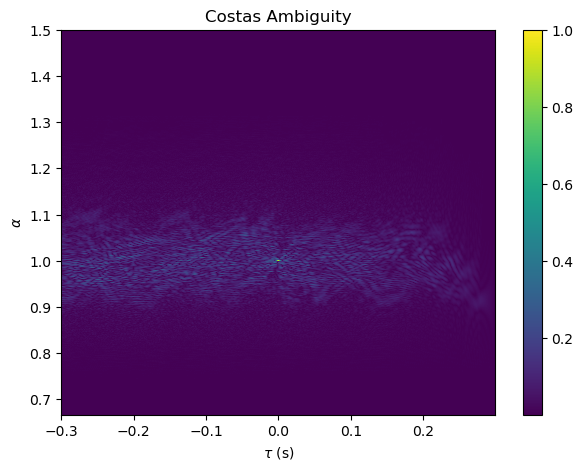

In [ ]:
from module.sequence import costas_seq
costas_list, method_list = costas_seq(30, num=3)
costas_list,method_list

costas_array = costas_list[0]

fc = 2000
B = 200
f_hop = B/len(costas_array)
f_start = fc - B/2
duration = 0.6
N = int(duration*fs)
sub_t_len = duration/len(costas_array)

sub_t = np.arange(0,0.02, 1/fs)

sig = np.concatenate([np.exp(1j*2*np.pi*(f_start+i*f_hop)*sub_t) for i in costas_array])


#绘制模糊函数
from tftb.processing.ambiguity import wide_band

waf, tau, log_theta = wide_band(sig, 0.2, 0.3, N)
tau = tau*(1/fs)
alpha = np.exp(log_theta)
TAU, ALPHA = np.meshgrid(tau, alpha)

    #等高线图
plt.figure(figsize=(5, 5))
plt.contour(tau, alpha, np.abs(waf)/np.max(np.abs(waf)))
plt.xlabel(r"$\tau$(s)")
plt.ylabel(r"$\alpha$")
plt.title("Costas Ambiguity(Contour)")
plt.show()


plt.figure(figsize=(7, 5))
plt.pcolormesh(TAU, ALPHA, np.abs(waf)/np.max(np.abs(waf)))
plt.colorbar()
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$\alpha$')
plt.title("Costas Ambiguity")
plt.show()

LFM与HFM

d:\anaconda3\.conda\envs\sig_processing\lib\site-packages\tftb\generators\frequency_modulated.py:68: UserWarning: Signal may be undersampled or may have negative frequencies.
  warnings.warn(msg, UserWarning)
C:\Users\ZaneSing\AppData\Local\Temp\ipykernel_4920\3148345927.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


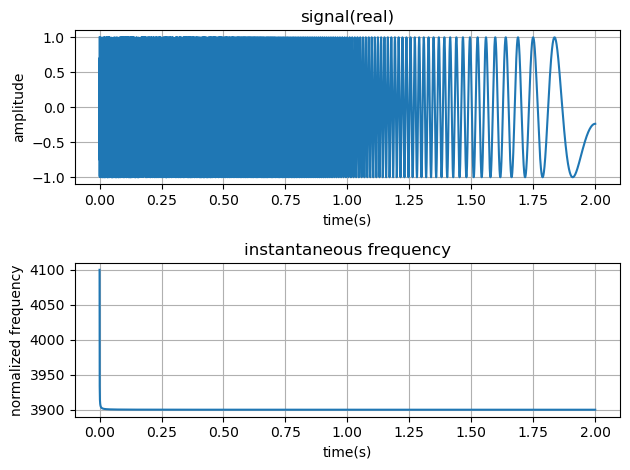

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tftb
from tftb.generators import fmhyp
fs = 9000

B = 200
fmax = 4000+B/2
fmin = 4000-B/2

t = np.arange(0,2,1/fs)
N = len(t)

#双曲调频信号
sig, iflaw = fmhyp(N, (1, fmax), (N-1, fmin))

n_axis = np.arange(len(sig))

fig,axs = plt.subplots(2,1)
axs[0].plot(t, sig.real);axs[0].set_title('signal(real)');axs[0].set_xlabel('time(s)');axs[0].set_ylabel('amplitude')
axs[0].grid(True)
axs[0].axis('tight')

axs[1].plot(t, iflaw);axs[1].set_title('instantaneous frequency');axs[1].set_xlabel('time(s)');axs[1].set_ylabel('normalized frequency')
axs[1].grid(True)
axs[1].axis('tight')

fig.tight_layout()
fig.show()


In [ ]:
#绘制模糊函数
from tftb.processing.ambiguity import wide_band

waf, tau, log_theta = wide_band(sig, 0.33, 0.35, N)
tau = tau*(1/fs)
alpha = np.exp(log_theta)

TAU, ALPHA = np.meshgrid(tau, alpha)

plt.pcolormesh(TAU, ALPHA, np.abs(waf)/np.max(np.abs(waf)))
plt.colorbar()
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$\alpha$')
plt.title("HFM Ambiguity")
plt.show()

Altes信号

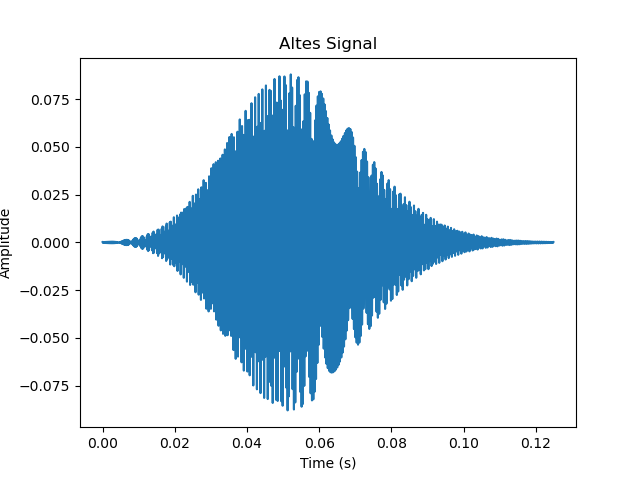

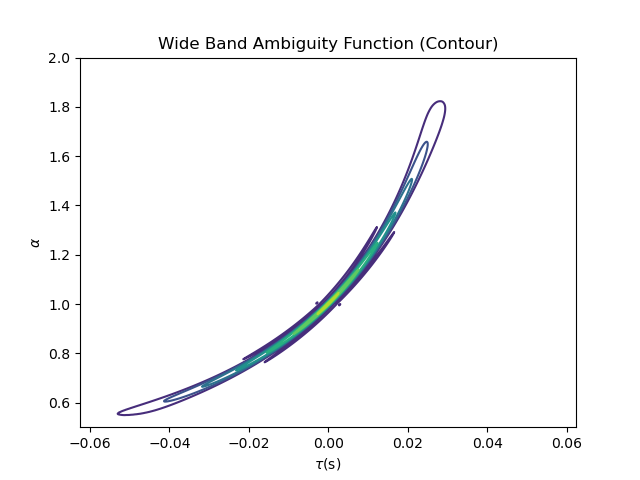

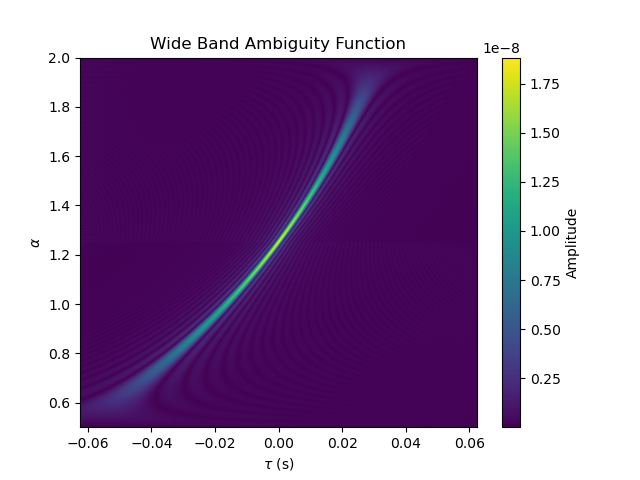

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from tftb.processing.ambiguity import wide_band



from tftb.generators import altes

def plot_altes_signal():
    SampleNum = 1000
    fmin,fmax = 1000,2000
    fs = 8000
    f_limit = fs/2
    t = np.arange(SampleNum)/fs

    fmin_norm,fmax_norm = fmin/f_limit,fmax/f_limit

    signal = altes(SampleNum, fmin_norm,fmax_norm)

    plt.figure()
    plt.plot(t,signal)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Altes Signal')
    plt.show()


    waf, tau, log_theta = wide_band(signal, 0.1, 0.2, SampleNum)
    tau = tau*(1/fs)
    alpha = np.exp(log_theta)

    #等高线图
    plt.figure()
    plt.contour(tau, alpha, np.abs(waf))
    plt.xlabel(r"$\tau$(s)")
    plt.ylabel(r"$\alpha$")
    plt.title("Wide Band Ambiguity Function (Contour)")
    #plt.colorbar()
    plt.show()

    #热图
    plt.figure()
    plt.imshow(np.abs(waf), 
            extent=[tau[0], tau[-1], alpha[0], alpha[-1]],
            aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Amplitude')
    plt.xlabel(r'$\tau$ (s)')
    plt.ylabel(r'$\alpha$')
    plt.title("Wide Band Ambiguity Function")
    plt.show()
plot_altes_signal()

